![banner](https://anopheles-genomic-surveillance.github.io/_images/banner.jpg)

***Training course in data analysis for genomic surveillance of African malaria vectors - Workshop 6***

---

# Module 1 - AgamPrimer - Primer Design in *Anopheles gambiae*

**Theme: Tools & technology**

This module introduces a new python package [AgamPrimer](https://github.com/sanjaynagi/AgamPrimer), which uses the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html) and [primer3-py](https://github.com/libnano/primer3-py), to allow us to design DNA primers for the major malaria mosquito, *Anopheles gambiae s.l*. This is useful, as it allows us to consider and avoid genetic variation in the Ag1000g resource during the design of our primers.

## Learning objectives

At the end of this module you will be able to:

- Explain what DNA primers are, and describe some of their applications.
- Explain why it is important to consider SNPs when designing primers.
- Design genomic DNA primers to target the *ace1*-G280S mutation.
- Design RT-qPCR primers to measure gene expression of the cytochrome P450, CYP9K1. 
- Design a set of primers in AgamPrimer batch mode to target multiple sites in the genome.

## Lecture
### English
### Francais

### Setup
Install and import the packages we'll need.

In [65]:
# First, install some packages we require
#!pip install AgamPrimer==0.4.6 primer3-py malariagen_data kaleido gget -q 

In [66]:
# Import libraries 
import AgamPrimer
import pandas as pd
import malariagen_data
import primer3
import gget

#configure plotting with matplotlib
%matplotlib inline
%config InlineBackend.figure_format = "retina"

Configure access to the MalariaGEN Ag3 data resource.

In [67]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Results cache           : None
Cohorts analysis        : 20220608
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 6.0.1
Client location         : England, GB
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

## Introduction
### Recap - Primers


A primer is a short single-stranded nucleic acid used by all living organisms in the initiation of DNA synthesis. DNA polymerase (responsible for DNA replication) enzymes are only capable of adding nucleotides to the 3’-end of an existing nucleic acid, requiring a primer be bound to the template before DNA polymerase can begin a complementary strand.

<img src="graphics/teaching/primer.png" alt="Drawing" style="width: 800px; height: 400px"/>

In many molecular biology applications we use synthetic DNA primers alongside the polymerase chain reaction (PCR) to amplify regions of DNA that we are interested in.

- PCR (Detection / Genotyping) 
- Real-time quantitative PCR  (Detection / Genotyping / Gene expression)
    - SYBR
    - Locked Nucleic Acid (LNA)
    - TaqMan
- Cloning
- Next generation sequencing
    - Amplicon sequencing

### Primer Design

Suitable primers are crucial to effective PCR reactions and must be designed to be robust, reliable and consistent across experimental conditions. 

Primers are typically designed with the following characteristics:

 - **Size**: Between 17-24 bases long
     - This can vary depending on the application. Often, hybridisation probes are shorter. Shorter primers may be less specific, whereas longer primers may have a slower hybridisation rate.
 - **Tm**: A Melting temperature of 59–64°C, with an ideal temperature of 62°C, which is based on typical PCR conditions and the optimum temperature for PCR enzymes.
 - **Ta**: The annealing temperature chosen for PCR relies directly on length and composition of the primers. This temperature should be no more than 5°C below the Tm of your primers.
 - **GC content**: Design your assay so that the GC content is 35–65%, with an ideal content of 50%, which allows complexity while still maintaining a unique sequence. Primer sequences should not contain regions of 4 or more consecutive G residues. 
 
Primers should also be free of strong secondary structures and self-complementarity. 

### SNPs / Mismatches in primer binding sites

<figure style="float: right; width: 500px;">
    <img src="graphics/teaching/primer_snp.png" alt="Drawing"/>
    <figcaption>Figure 2: Mismatches reduce the efficiency of primer extension<sup>[1]</sup><br>.</figcaption>
</figure>

Single nucleotide polymorphisms (SNPs) in primer binding sites can affect both the stability and *Tm* of the primer-template duplex, as well as the efficiency with which DNA polymerases can extend the primer (Figure 2). In some cases, this can completely prevent primer binding and amplification of the template DNA, often referred to as null alleles. If performing PCR on individual samples, this phenomenon can usually be identified with repeated, failed efforts to amplify. However, null alleles can become particular troublesome when performing PCR on pooled samples, where we may not observe whether all samples amplified successfully, and so we may not be sampling and observing the full range of alleles.

<figure style="float: right; width: 500px;">
    <img src="graphics/teaching/snps_primer.jpg" alt="Drawing"/>
    <figcaption>Figure 3: Mismatches at the 3’ end of primers substantially reduce qPCR performance <sup>[1]</sup>.</figcaption>
</figure>

An equally problematic scenario may occur if primers bind but with unequal efficiency against different genetic variants. In this case, in any quantitative molecular assay such as qPCR for gene expression, SNPs could lead to biases in the estimation of gene expression between genetic variants or strains. Even single mismatches can introduce a variety of effects, ranging from minor to major impacts on Cq values <sup>[1]</sup>. The effect will depend on the type of mismatch (which nucleotides are involved), and on the position of the SNP (3’ or 5’ end), as mismatches within the last 5 nucleotides at the 3’ end can disrupt the nearby polymerase active site, and so these mismatches tend to have a much greater impact <sup>[2]</sup>. Mismatches at the terminal 3’ base had the strongest shift of Cq, altering Cq by as much as 5–7 cycles (Figure 3).

To maximise the accuracy of our data we should therefore aim to either design primers that avoid SNPs completely or that contain a mix of bases (degenerate) at the sites of SNPs. There is a useful article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays).

<br> 
<br>

### Ag1000g

As we have seen in earlier workshops, the Ag1000g resource <sup>[3]</sup> has revealed extreme amounts of [genetic variation in *Anopheles gambiae s.l*](https://genome.cshlp.org/content/30/10/1533.full). You can find a SNP in less than every 2 bases of the accessible genome - which makes considering SNPs even more important when designing molecular assays. However, it was not previously straightforward to consider genetic variation when designing primers, and so the vast majority of primers currently in use did not consider SNP variation during their design.

Primer3 is the most widely cited program for primer design, and has been used extensively over the past two decades <sup>[4]</sup>. It is also the primer design engine behind [Primer-BLAST](https://www.ncbi.nlm.nih.gov/tools/primer-blast/) <sup>[5]</sup>, a web-server which designs primers and then blasts the primers to check for specificity. Thanks to the [primer3-py](https://github.com/libnano/primer3-py) python package and the fantastic [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html), it is now possible to design primers in the cloud with google colab, considering SNP variation.

---

## Designing primers for the *ace1*-280S mutation

In the rest of this module, we will design primers and probes for the *ace1*-280S mutation (previously *ace1*-119S). This mutation is known to be important in resistance to organophosphates and carbamates, insecticides which are widely used in indoor residual spraying (IRS). The resistance mutation has spread throughout much of west and central Africa, including introgressing from *An. gambiae* to *An. coluzzii*, and is often found on the background of large duplications which often pair wild-type and mutant alleles <sup>[6]</sup>. We see very large signals of selection at this locus in many contemporary populations of *An. gambiae*. 

  ----



<figure style="width: 800px;">
    <img src="graphics/teaching/ace1.png" alt="Drawing"/>
    <figcaption>Combination of Ace1 genotypes and CNVs, taken from Grau-Bove et al.<sup>[6]</sup></figcaption>
</figure>


### Selecting our design parameters

In [68]:
#@title **Selecting Primer Parameters** { run: "auto" }
#@markdown In the below cells, replace the values with those desired for your primers.

assay_type = "gDNA primers + probe"           #@param ["gDNA primers", "gDNA primers + probe", "probe", "qPCR primers"]
assay_name = 'ace1-280s'                            #@param {type:"string"}
min_amplicon_size = 60                        #@param {type:"integer"}
max_amplicon_size = 120                       #@param {type:"integer"}
amplicon_size_range = [[min_amplicon_size, max_amplicon_size]]
n_primer_pairs = 6                            #@param {type:"slider", min:1, max:20, step:1}

#@markdown    
#@markdown target_loc is required for gDNA primers and probes, and transcript required for qPCR primers.
contig =  "2R"                                 #@param ['2L', '2R', '3L', '3R', 'X']

target_loc =  '3492074'                       #@param {type:"string"}
target_loc = int(target_loc)
transcript =  ''                               #@param {type:"string"} 


if any(item in assay_type for item in ['gDNA', 'probe']):
  assert target_loc > 0, "Target location must be above 0 and less than the contig length"
elif assay_type == 'qPCR primers':
  assert len(transcript) > 2, "Transcript ID is not valid, should be vectorbase ID such as 'AGAP004707-RD'"

Load sequence data for the chromosomal arm of choice, using the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html):

In [69]:
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for 2R is 61545105 bp long


In [70]:
genome_seq

dask.array<array, shape=(61545105,), dtype=|S1, chunksize=(10000000,), chunktype=numpy.ndarray>

Now we need to extract the bit of genome sequence we need. We will use functions in the [AgamPrimer](https://pypi.org/project/AgamPrimer/) package. For genomic DNA primers, this is quite simple and we can make direct use of the `ag3.genome_sequence()` function, but for cDNA qPCR primers, we must only include coding sequence, and so we must concatenate exons together.

With qPCR primers for cDNA, we also must ensure that one primer spans an exon-exon junction, to ensure that any residual genomic DNA in our samples does not get amplified. We must therefore make a note of where the exon junctions are, and we store that as a list in the `exon_junctions` variable.

In [71]:
if any(item in assay_type for item in ['gDNA', 'probe']):
  # genomic DNA
  target_sequence, gdna_pos, seq_parameters = AgamPrimer.prepare_gDNA_sequence(target_loc=target_loc, amplicon_size_range=amplicon_size_range, genome_seq=genome_seq, assay_name=assay_name, assay_type=assay_type)
elif assay_type == 'qPCR primers':
  # RT-quantitative PCR, cDNA
  target_sequence, exon_junctions, gdna_pos, seq_parameters = AgamPrimer.prepare_cDNA_sequence(transcript=transcript, gff=ag3.geneset(), genome_seq=genome_seq, assay_name=assay_name)

The target sequence is 179 bases long
the target snp is 89 bp into our target sequence


Now we have our target sequence. Lets take a look...

In [72]:
seq_parameters['SEQUENCE_TEMPLATE']

'CCCTGTCCGAGGACTGTCTGTACATTAACGTGGTGGCACCGCGACCCCGGCCCAAGAATGCGGCCGTCATGCTGTGGATCTTCGGCGGCGGCTTCTACTCCGGCACCGCCACCCTGGACGTGTACGACCACCGGGCGCTTGCGTCGGAGGAGAACGTGATCGTGGTGTCGCTGCAGTAC'

We need to set up a second python dictionary, which will be our input to primer3. This contains our preferred primer parameters. In the below cell, you can modify or add primer3 parameters, such as optimal primer size, TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 2.3.7 manual](https://htmlpreview.github.io/?https://github.com/libnano/primer3-py/master/primer3/src/libprimer3/primer3_manual.htm).

In [73]:
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 55.0,
        'PRIMER_MAX_TM': 64.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3,          # this parameter is the minimum distance between successive pairs. If 1, it means successive primer pairs could be identical bar one base shift
        'PRIMER_INTERNAL_OPT_SIZE': 16,               # Probe size preferences if selected, otherwise ignored
        'PRIMER_INTERNAL_MIN_SIZE': 10,
        'PRIMER_INTERNAL_MAX_SIZE': 22,
        'PRIMER_INTERNAL_MIN_TM': 45,
        'PRIMER_INTERNAL_MAX_TM':65,                # Probe considerations are quite relaxed, assumed that LNAs will be used later to affect TM
        # Extra primer3 parameters can go here
        # In the same format as above                       
    }

## adds some necessary parameters depending on assay type
primer_parameters = AgamPrimer.primer_params(primer_parameters, assay_type) 

#### **Run the primer3 algorithm!**

In [75]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

It should be *fast*. The output, which we store as 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe containing just the necessary bits of information. First, we'll print some information from the primer3 run.

In [77]:
AgamPrimer.primer3_run_statistics(primer_dict, assay_type)

primer_forward_explain  :  considered 556, GC content failed 81, low tm 70, high tm 193, ok 212 

primer_reverse_explain  :  considered 484, GC content failed 62, low tm 11, high tm 242, high hairpin stability 17, ok 152 

primer_probe_explain  :  considered 368, overlap excluded region 160, GC content failed 16, low tm 64, high tm 2, high hairpin stability 4, ok 122 

primer_pair_explain  :  considered 374, unacceptable product size 366, primer in pair overlaps a primer in a better pair 727, ok 8 

primer_forward_num_returned  :  6 

primer_reverse_num_returned  :  6 

primer_probe_num_returned  :  6 

primer_pair_num_returned  :  6 



Now lets convert this into an easy to read pandas dataframe.

In [78]:
primer_df = AgamPrimer.primer3_to_pandas(primer_dict, assay_type)
primer_df

primer_pair,0,1,2,3,4,5
parameter,,,,,,
primer_forward_sequence,TCATGCTGTGGATCTTCGGC,GCCGTCATGCTGTGGATCTT,CAAGAATGCGGCCGTCATG,ACATTAACGTGGTGGCACCG,GGCCGTCATGCTGTGGAT,CTGTGGATCTTCGGCGGC
primer_reverse_sequence,GATCACGTTCTCCTCCGACG,GTCGTACACGTCCAGGGTG,GTTCTCCTCCGACGCAAGC,CGGTGGTCGTACACGTCC,TACTGCAGCGACACCACGAT,AGCGACACCACGATCACG
primer_probe_sequence,GCGGCTTCTACTCCGGCA,GCGGCGGCTTCTACTCCGG,TGGATCTTCGGCGGCGGC,TGGATCTTCGGCGGCGGC,GCGGCGGCTTCTACTCCGG,GGCTTCTACTCCGGCA
primer_forward_tm,60.462581,60.745845,59.936994,61.231958,60.12457,60.892425
primer_reverse_tm,60.248134,60.080974,61.095252,60.126734,61.87327,60.126463
primer_probe_tm,56.445018,59.897635,59.805464,59.805464,59.897635,49.485421
primer_forward_gc_percent,55.0,55.0,57.894737,55.0,61.111111,66.666667
primer_reverse_gc_percent,60.0,63.157895,63.157895,66.666667,55.0,61.111111
primer_probe_gc_percent,66.666667,73.684211,72.222222,72.222222,73.684211,62.5



We can write this to .tsv and excel files, which can be explored in other editors.

In [79]:
primer_df.to_csv(f"{assay_name}.{assay_type}.primers.tsv", sep="\t")
primer_df.to_excel(f"{assay_name}.{assay_type}.primers.xlsx")

## **Looking for variation using the ag1000g resource and malariagen API**

As we've seen in earlier workshops, ag1000g samples are organised into sample sets. Lets look at what each sample set contains, breaking it down by species, year and country. 

In [80]:
metadata = ag3.sample_metadata()

pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

pivot_country_year_taxon

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

taxon                                                arabiensis  coluzzii  \
sample_set   year  country                                                  
AG1000G-AO    2009 Angola                                     0        81   
AG1000G-BF-A  2012 Burkina Faso                               0        82   
AG1000G-BF-B  2014 Burkina Faso                               3        53   
AG1000G-BF-C  2004 Burkina Faso                               0         0   
AG1000G-CD    2015 Democratic Republic of the Congo           0         0   
AG1000G-CF    1993 Central African Republic                   0         5   
              1994 Central African Republic                   0        13   
AG1000G-CI    2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A  2009 Cameroon                                   0         0   
AG1000G-CM-B  2005 Cameroon                                   0         7   
AG1000G-CM-C  2013 Cameroon                                   2        19   
AG1000G-FR    2011 Mayotte                                    0         0   
AG1000G-GA-A  2000 Gabon                                      0         0   
AG1000G-GH    2012 Ghana                                      0        64   
AG1000G-GM-A  2011 Gambia, The                                0         0   
AG1000G-GM-B  2012 Gambia, The                                0         2   
AG1000G-GM-C  2012 Gambia, The                                0        12   
AG1000G-GN-A  2012 Guinea                                     0         4   
AG1000G-GN-B  2012 Guinea                                     0         7   
                   Mali                                       0        28   
AG1000G-GQ    2002 Equatorial Guinea                          0         0   
AG1000G-GW    2010 Guinea-Bissau                              0         0   
AG1000G-KE    2000 Kenya                                      0         0   
              2007 Kenya                                      3         0   
              2012 Kenya                                     10         0   
AG1000G-ML-A  2014 Mali                                       0        27   
AG1000G-ML-B  2004 Mali                                       2        36   
AG1000G-MW    2015 Malawi                                    41         0   
AG1000G-MZ    2003 Mozambique                                 0         0   
              2004 Mozambique                                 0         0   
AG1000G-TZ    2012 Tanzania                                  87         0   
              2013 Tanzania                                   1         0   
              2015 Tanzania                                 137         0   
AG1000G-UG    2012 Uganda                                    82         0   
AG1000G-X    -1    Lab Cross                                  0        74   

taxon                                                gambiae  gcx1  gcx2  \
sample_set   year  country                                                 
AG1000G-AO    2009 Angola                                  0     0     0   
AG1000G-BF-A  2012 Burkina Faso                           98     0     0   
AG1000G-BF-B  2014 Burkina Faso                           46     0     0   
AG1000G-BF-C  2004 Burkina Faso                           13     0     0   
AG1000G-CD    2015 Democratic Republic of the Congo       76     0     0   
AG1000G-CF    1993 Central African Republic                2     0     0   
              1994 Central African Republic               53     0     0   
AG1000G-CI    2012 Cote d'Ivoire                           0     0     0   
AG1000G-CM-A  2009 Cameroon                              303     0     0   
AG1000G-CM-B  2005 Cameroon                               90     0     0   
AG1000G-CM-C  2013 Cameroon                               23     0     0   
AG1000G-FR    2011 Mayotte                                23     0     0   
AG1000G-GA-A  2000 Gabon                                  69     0     0   
AG1000G-GH

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [82]:
sample_set = 'AG1000G-GH'          # sample_set = '3.0' .you can also supply lists with multiple sample sets e.g ['AG1000G-GH', 'AG1000G-CI', 'AG1000G-BF-A]
sample_query = None #"aim_species == 'coluzzii'"                # here we can subset to specific values in the metadata e.g :     "aim_species == 'gambiae'" , or "aim_species == 'arabiensis'"          

### **Plot allele frequencies in primers locations**

Now we can plot the primers pairs, and the frequency of any alternate alleles in the Ag1000g sample set of choice. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. We can see the frequencies of specific alleles by hovering over the points of the plot - in some cases it may be preferable to design degenerate primers rather than avoid a primer pair completely.

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this plot to identify primers pairs and probes which may be suitable, particularly trying to avoid SNPs in the 3' end. 

In [83]:
results_dict = AgamPrimer.plot_primer_ag3_frequencies(primer_df=primer_df,
                                                gdna_pos=gdna_pos,
                                                contig=contig,
                                                sample_set=sample_set, 
                                                sample_query=sample_query,
                                                assay_type=assay_type,
                                                seq_parameters=seq_parameters,
                                                save=True)

Thu Sep  1 14:16:16 2022 DEBUG snp_calls: normalise parameters
Thu Sep  1 14:16:16 2022 DEBUG snp_calls: access SNP calls and concatenate multiple sample sets and/or regions
Thu Sep  1 14:16:16 2022 DEBUG _snp_calls_dataset: call arrays
Thu Sep  1 14:16:16 2022 DEBUG _snp_calls_dataset: sample arrays
Thu Sep  1 14:16:16 2022 DEBUG _snp_calls_dataset: create a dataset
Thu Sep  1 14:16:16 2022 DEBUG snp_calls: concatenate data from multiple sample sets
Thu Sep  1 14:16:16 2022 DEBUG snp_calls: add variants variables
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: variant arrays
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: variant_position
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: variant_allele
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: variant_contig
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: site filters arrays
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: set up attributes
Thu Sep  1 14:16:16 2022 DEBUG _snp_variants_dataset: cr

Thu Sep  1 14:16:28 2022 DEBUG _snp_variants_dataset: variant_contig
Thu Sep  1 14:16:28 2022 DEBUG _snp_variants_dataset: site filters arrays
Thu Sep  1 14:16:28 2022 DEBUG _snp_variants_dataset: set up attributes
Thu Sep  1 14:16:28 2022 DEBUG _snp_variants_dataset: create a dataset
Thu Sep  1 14:16:28 2022 DEBUG snp_calls: handle site class
Thu Sep  1 14:16:28 2022 DEBUG snp_calls: handle region, do this only once - optimisation
Thu Sep  1 14:16:29 2022 DEBUG snp_calls: concatenate data from multiple regions
Thu Sep  1 14:16:29 2022 DEBUG snp_calls: apply site filters
Thu Sep  1 14:16:29 2022 DEBUG snp_calls: add call_genotype_mask
Thu Sep  1 14:16:29 2022 DEBUG snp_calls: handle sample query
Thu Sep  1 14:16:29 2022 DEBUG snp_calls: handle cohort size


Now lets plot these primer pairs across the genome, highlighting where they are in relation to any nearby exons...

Thu Sep  1 14:19:25 2022 DEBUG geneset: handle region


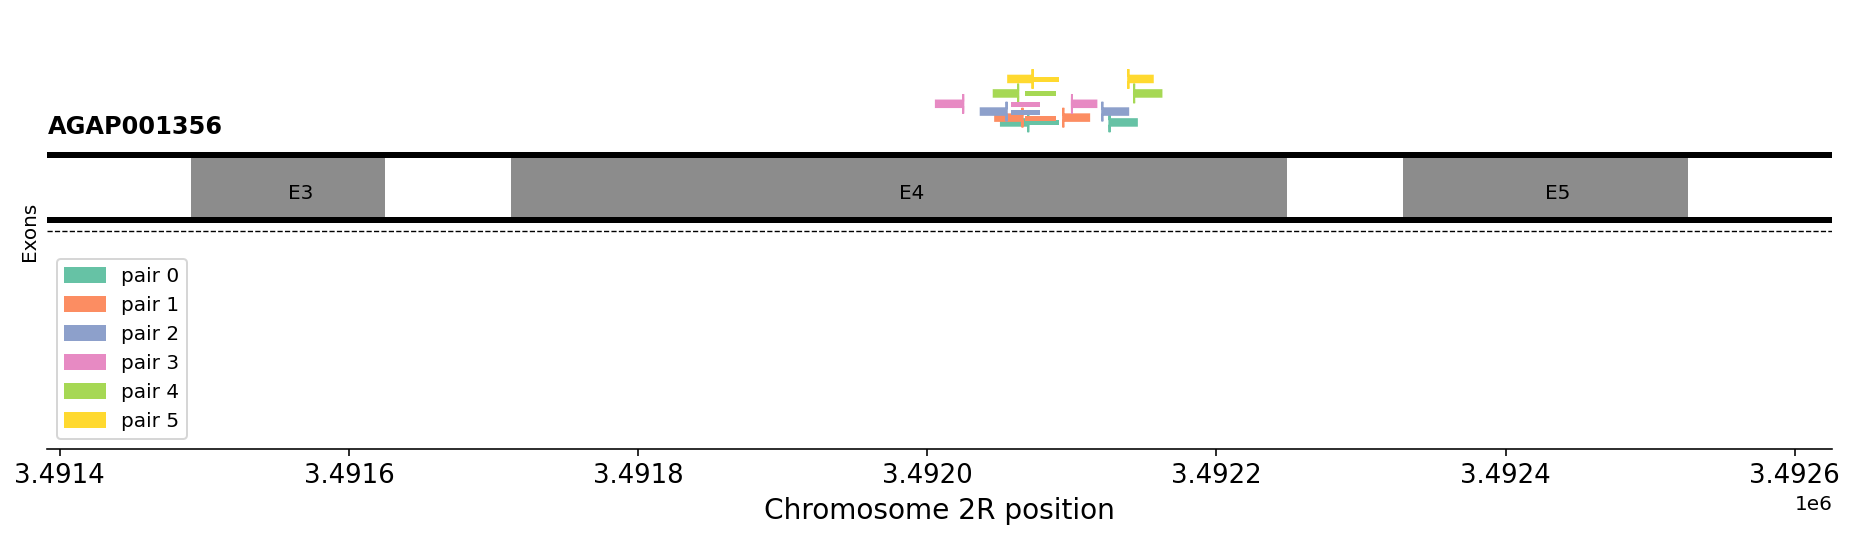

In [84]:
AgamPrimer.plot_primer_locs(primer_res_dict=results_dict, primer_df=primer_df, assay_type=assay_type, gff=ag3.geneset(), contig=contig, seq_parameters=seq_parameters, legend_loc='lower left')

### **Checking our primers for specificity to the *Anopheles gambiae* genome**

We can use a cool new python package, [gget](https://github.com/pachterlab/gget), to rapidly search our primers against the AgamP3 genome, to ensure they will not amplify any other regions of the genome. gget rapidly queries large databases - in this case we can use the program BLAT to align primer sequences. Unfortunately as the lengths of primer sequences are so short, it is at the limit of BLATs sensitivity, and in some cases, matches are not returned. gget can also currently only query the older AgamP3 assembly. Therefore, it is also recommended run a more exhaustive search in [Primer-BLAST](https://www.ncbi.nlm.nih.gov/tools/primer-blast/).

In [85]:
blat_result_df = AgamPrimer.gget_blat_genome(primer_df, assay_type, assembly='anoGam3')
blat_result_df

Thu Sep  1 14:21:27 2022 INFO No DNA BLAT matches were found for this sequence in genome anoGam3.


No hit for probe - pair 0


Thu Sep  1 14:21:31 2022 INFO No DNA BLAT matches were found for this sequence in genome anoGam3.


No hit for forward - pair 2


Thu Sep  1 14:21:42 2022 ERROR 
            BLAT of seqtype 'DNA' using assembly 'anoGam3' was unsuccesful. 
            Possible causes: 
            - Sequence possibly too short (required minimum: 20 characters). 
            - Assembly possibly invalid. All available species with their respective assemblies are listed at https://genome.ucsc.edu/cgi-bin/hgBlat.
            


No hit for probe - pair 5


genome  query_size  aligned_start  aligned_end  matches  \
  primer                                                                
0 forward_0  anoGam3          20              1           20       20   
  reverse_0  anoGam3          20              1           20       20   
1 forward_1  anoGam3          20              1           20       20   
  reverse_1  anoGam3          19              1           19       19   
  probe_1    anoGam3          19              1           19       19   
2 reverse_2  anoGam3          19              1           19       19   
  probe_2    anoGam3          18              1           18       18   
3 forward_3  anoGam3          20              1           20       20   
  reverse_3  anoGam3          18              1           18       18   
  probe_3    anoGam3          18              1           18       18   
4 forward_4  anoGam3          18              1           18       18   
  reverse_4  anoGam3          20              1           20       20   
  probe_4    anoGam3          19              1           19       19   
5 forward_5  anoGam3          18              1           18       18   
  reverse_5  anoGam3          18              1           18       18   

             mismatches  %_aligned  %_matched chromosome strand    start  \
  primer                                                                   
0 forward_0           0      100.0      100.0      chr2R      +  3492051   
  reverse_0           0      100.0      100.0      chr2R      -  3492126   
1 forward_1           0      100.0      100.0      chr2R      +  3492047   
  reverse_1           0      100.0      100.0      chr2R      -  3492094   
  probe_1             0      100.0      100.0      chr2R      +  3492069   
2 reverse_2           0      100.0      100.0      chr2R      -  3492121   
  probe_2             0      100.0      100.0      chr2R      +  3492059   
3 forward_3           0      100.0      100.0      chr2R      +  3492006   
  reverse_3           0      100.0      100.0      chr2R      -  3492100   
  probe_3             0      100.0      100.0      chr2R      +  3492059   
4 forward_4           0      100.0      100.0      chr2R      +  3492046   
  reverse_4           0      100.0      100.0      chr2R      -  3492143   
  probe_4             0      100.0      100.0      chr2R      +  3492069   
5 forward_5           0      100.0      100.0      chr2R      +  3492056   
  reverse_5           0      100.0      100.0      chr2R      -  3492139   

                 end  
  primer              
0 forward_0  3492070  
  reverse_0  3492145  
1 forward_1  3492066  
  reverse_1  3492112  
  probe_1    3492087  
2 reverse_2  3492139  
  probe_2    3492076  
3 forward_3  3492025  
  reverse_3  3492117  
  probe_3    3492076  
4 forward_4  3492063  
  reverse_4  3492162  
  probe_4    3492087  
5 forward_5  3492073  
  reverse_5  3492156

#### **We may now have designed suitable primers. However, there are some further considerations...**


- Primers should be run in [**Primer-BLAST**](https://www.ncbi.nlm.nih.gov/tools/primer-blast/), to ensure specificity against the host organism, and specificity for the genomic location of interest.

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated on a one by one basis using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer), though higher throughput algorithms may be required.

- If designing Locked Nucleic Acid (LNA) probes for SNP detection, you will want to play around with the placement of LNAs in the oligo sequence, which can allow short probes (~10-14 bases) to bind with high affinity and discriminate between SNPs. IDT have a tool for this which allow you to check the binding affinity between mismatches, though it requires a log in https://eu.idtdna.com/calc/analyzer/lna. 

- Many more considerations.... [IDT - How to design primers and probes for PCR and qPCR](https://eu.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes)   

---

### Well done!!

Well done on completing the notebook and hopefully designing sets of SNP-variation informed primers!

---

### Exercises

For the exercises, you may wish to open the [AgamPrimer notebook](https://colab.research.google.com/github/sanjaynagi/AgamPrimer/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb) rather than re-run this one.

**1)** Design a set of qPCR primers for the Cytochrome P450 gene, CYP9K1 (AGAP000818), restricting the samples to just *Anopheles coluzzii*.

**2)** Design a set of primers and a probe for the *vgsc*-995F *kdr* mutation (contig = 2L, genome bp = 2422652)

**3)** Use the batch mode of AgamPrimer (link) to design a set of primers for multiple loci.

---
### **Future development**

Any contributions or suggestions on how we can improve this notebook are more than welcome. Please [email](mailto:sanjay.nagi@lstmed.ac.uk) or log an [issue on github](https://github.com/sanjaynagi/primerDesignAg/issues). This notebook and source code for AgamPrimer are located here - https://github.com/sanjaynagi/AgamPrimer/    

---


### **References**

[1] Lefever S, Pattyn F, et al. (2013) **Single-nucleotide polymorphisms and other mismatches reduce performance of quantitative PCR assays. Single-nucleotide polymorphisms and other mismatches reduce performance of quantitative PCR assays**. Clin Chem, 59(10):1470–1480.

[2] Owczarzy R, Tataurov AV, et al. (2008) **IDT SciTools: a suite for analysis and design of nucleic acid oligomers**. Nucl Acids Res, 36 (suppl 2):W163–169.

[3] The Anopheles gambiae 1000 Genomes Consortium (2020). **Genome variation and population structure among 1142 mosquitoes of the African malaria vector species *Anopheles gambiae* and *Anopheles coluzzii***. *Genome Research*, **30**: 1533-1546. 
https://genome.cshlp.org/content/early/2020/09/25/gr.262790.120

[4] Untergasser A, Cutcutache I, Koressaar T, Ye J, Faircloth BC, Remm M and Rozen SG (2012). **Primer3--new capabilities and interfaces**. *Nucleic Acids Research*. 40(15):e115.

[5] Ye, J., Coulouris, G., Zaretskaya, I. et al. **Primer-BLAST: A tool to design target-specific primers for polymerase chain reaction**. BMC Bioinformatics 13, 134 (2012). https://doi.org/10.1186/1471-2105-13-134